### **1. Import Libaries and Load Data**

In [12]:
import os
import mlflow
import pycaret
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.regression import *
from pycaret.distributions import UniformDistribution, DiscreteUniformDistribution, CategoricalDistribution, IntUniformDistribution

In [13]:
pd.set_option('display.float_format', '{:.2f}'.format)
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [14]:
data = pd.read_excel('../data/raw/02_Used_Car_Prices.xlsx')

### **2. EDA & Data Processing**

In [15]:
data.head()

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.00,175000.00
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.00,1250000.00
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.00,450000.00
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.00,600000.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.00,1774000.00


We can observe columns such as Mileage, Engine and power are aphanumeric values. We will extract the numerical values from these columns and convert them to float before proceeding with the analysis. This will treat theses columns as numerical columns allowing us to analyze them better.

In [16]:
data['Mileage'] = data['Mileage'].str.extract('(\d+\.?\d*)')[0].astype(float)
data['Engine'] = data['Engine'].str.extract('(\d+)')[0].astype(float)
data['Power'] = data['Power'].str.extract('(\d+\.?\d*)')[0].astype(float)

In [17]:
def extract_brand(entry):
    parts = entry.capitalize().split()
    if len(parts) >= 2 and parts[0] == 'Land' and parts[1] == 'rover':
        return 'Land Rover'
    else:
        return parts[0]
    
data["Brand"] = data["Brand_Model"].apply(extract_brand)

We will also be extracting the brand name from Brand_Model column, this provides us with the brand of the car which can be used for further analysis and model building.

In [18]:
# print unique values of the 'Brand' column
data['Brand'].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land Rover', 'Mitsubishi', 'Renault',
       'Mercedes-benz', 'Bmw', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'Force', 'Bentley', 'Lamborghini'],
      dtype=object)

In [19]:
luxury_brands = [
    'audi', 'bmw', 'mercedes-benz', 
    'porsche', 'jaguar', 'land rover',
    'volvo', 'bentley', 'lamborghini'
]

# create a new column 'Luxury_Flag' that is 1 if the 'Brand' is in the luxury_brands list and 0 otherwise
data['Luxury_Flag'] = data['Brand'].str.lower().isin(luxury_brands).astype(int)

We will create a luxury flag based on the brand of the car. We will use domain knowledge to identify the luxury brands and assign a flag to them. For example brands such as BMW, Audi, Mercedes will be considered as luxury brands as they are known for their luxury cars.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand_Model        6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  Price (INR Lakhs)  6019 non-null   float64
 12  Brand              6019 non-null   object 
 13  Luxury_Flag        6019 non-null   int32  
dtypes: float64(5), int32(1), int64(2), object(6)
memory usage: 634.9+ KB


There are total of 6019 rows and 13 columns in the datase, and we can observe that there are missing values in columns.

In [21]:
print(f'Missing Values:\n{data.isnull().sum()}')

Missing Values:
Brand_Model            0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price (INR Lakhs)      0
Brand                  0
Luxury_Flag            0
dtype: int64


In [22]:
data.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price (INR Lakhs),Luxury_Flag
count,6019.00,6019.00,6017.00,5983.00,5876.00,5977.00,6019.00,6019.00
mean,2013.36,58738.38,18.13,1621.28,113.25,5.28,947946.84,0.16
std,3.27,91268.84,4.58,601.36,53.87,0.81,1118791.71,0.37
min,1998.00,171.00,0.00,72.00,34.20,0.00,44000.00,0.00
25%,2011.00,34000.00,15.17,1198.00,75.00,5.00,350000.00,0.00
50%,2014.00,53000.00,18.15,1493.00,97.70,5.00,564000.00,0.00
75%,2016.00,73000.00,21.10,1984.00,138.10,5.00,995000.00,0.00
max,2019.00,6500000.00,33.54,5998.00,560.00,10.00,16000000.00,1.00


- **Year:** The cars in the dataset have an average year of 2013 and most vehicles falling between 2011 and 2016.

- **Kilometers_Driven:** The average distance driven is approximately 58,738 km with a extreme outliers showing 6.5 million km which is likely an error or a extremely high mileage vehicle.
- **Mileage:** The average fuel efficiency is around 18.1 km/l, with half of the cars ranging between 15.17 and 21.1 km/l, though some values like "0" may indicate errors or electric vehicles.
- **Engine:** The average engine size is 1621 cc, with most cars falling between 1198 and 1984 cc, but outlier values like 72 cc and 5998 cc could suggest a mix of vehicle types like motorcycles and trucks.
- **Power:** The average power output is 113 bhp, with half of the cars having < 97.7 bhp, while high-performance outliers reach up to 560 bhp.
- **Seats:** Most cars have 5 seats, though the range extends from 0 (likely a error) to 10, indicating larger vehicles like vans or buses.
- **Price:** The average price is around 948000 lakhs, with half of the cars priced below 564000 lakhs, though luxury vehicles push the maximum price to 16000000 lakhs which could be an outlier such as a vintage car or a high-end supercar.

In [23]:
zero_seat = data[data['Seats'] == 0]
zero_seat

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs),Brand,Luxury_Flag
3999,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000,Petrol,Automatic,First,10.50,3197.00,NaN,0.00,1800000.00,Audi,1


In [24]:
# impute the 0 seat value with 5
data['Seats'] = data['Seats'].replace(0, 5)

Since there is only one row with 0 seats, we will impute it. With a quick search, on google the car is a 5 seater.

In [25]:
# duplicates
print(f'Duplicates: {data.duplicated().sum()}')

Duplicates: 0


No duplicates are found in the dataset.

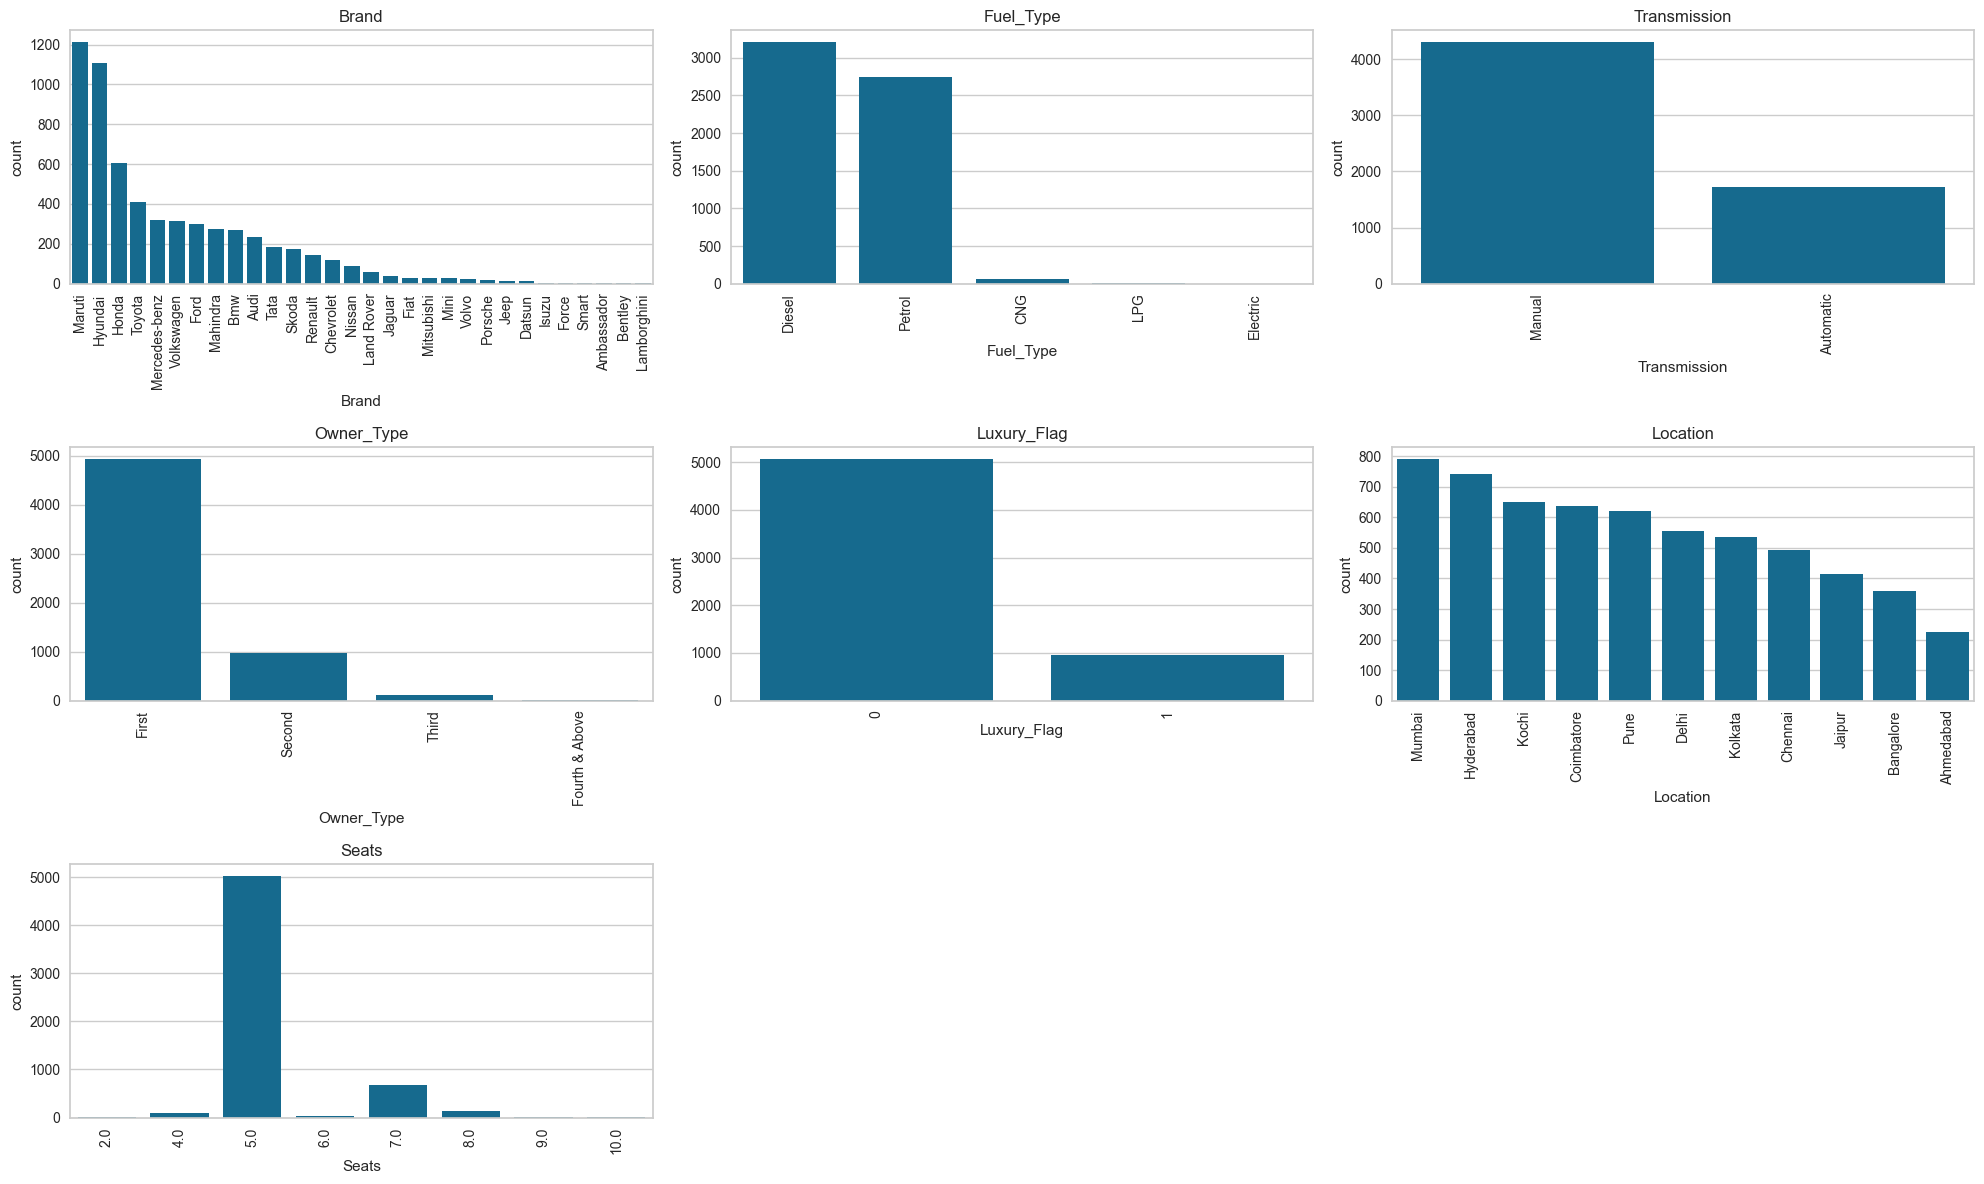

In [26]:
categorical_col = ['Brand', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Luxury_Flag', 'Location', 'Seats']

# plot the categorical columns
plt.figure(figsize=(20, 12))
for i, col in enumerate(categorical_col):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x=data[col].value_counts().index, y=data[col].value_counts())
    plt.title(col)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

- **Brand**: Maruti, Hyundai, and Honda are the most popular brands, with Maruti dominating the market.  

- **Fuel_Type**: Diesel and Petrol vehicles are more common than CNG (Compressed Natural Gas) or LPG (Liquefied Petroleum Gas) and Electric vehicles.
- **Transmission**: Manual transmission is far more prevalent than automatic.
- **Owner_Type**: Most vehicles are first or second-hand, with very few third or more than 4 owners.
- **Luxury_Flag**: Non-luxury vehicles (flagged as 0) are more common than luxury vehicles (flagged as 1).
- **Location**: Mumbai and Hyderabad have the highest concentration of vehicles, followed by Kolkata and Chennai.  
- **Seats**: 5-seater vehicles are the most common, indicating a standard sedan or hatchback. With 7-seater vehicles being the next most common, likely SUVs or vans.

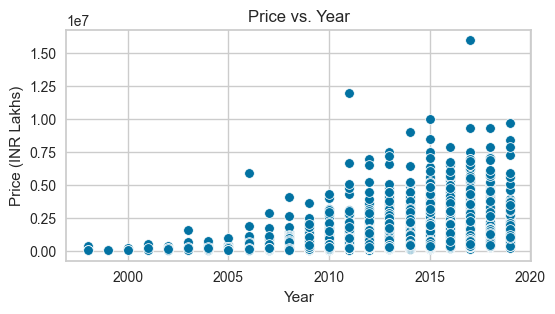

In [27]:
# Price vs. Year
plt.figure(figsize=(6, 3))
sns.scatterplot(x='Year', y='Price (INR Lakhs)', data=data)
plt.title('Price vs. Year')
plt.show()

Here we can observe as year increases the price of the car also increases which is expected as newer cars are more expensive than older cars.

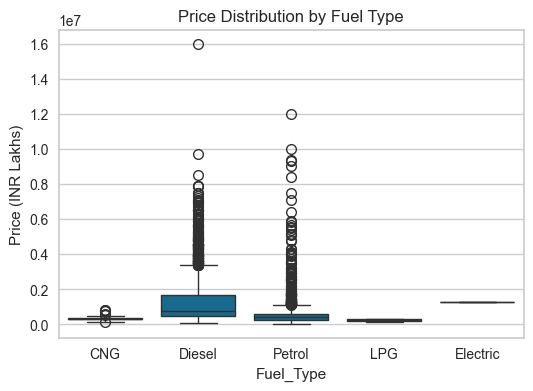

In [28]:
# Boxplot of Price by Fuel_Type
plt.figure(figsize=(6, 4))
sns.boxplot(x='Fuel_Type', y='Price (INR Lakhs)', data=data)
plt.title('Price Distribution by Fuel Type')
plt.show()

Diesel cars are slightly more expensive and have higher price variability than petrol cars on average. With electric cars being the most expensive, but this could be due to the small sample size. LPG and CNG cars are the least expensive, but again this could be due to the small sample size.

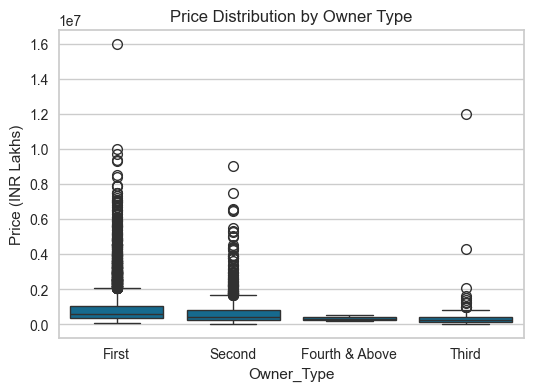

In [29]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Owner_Type', y='Price (INR Lakhs)', data=data)
plt.title('Price Distribution by Owner Type')
plt.show()

First owner cars are more expensive than second owner cars, as price decreases as the number of owners increases. This is expected as the car value decreases with the number of owners which is a common trend in the used car market possibly due to wear and tear, maintenance, and mileage.

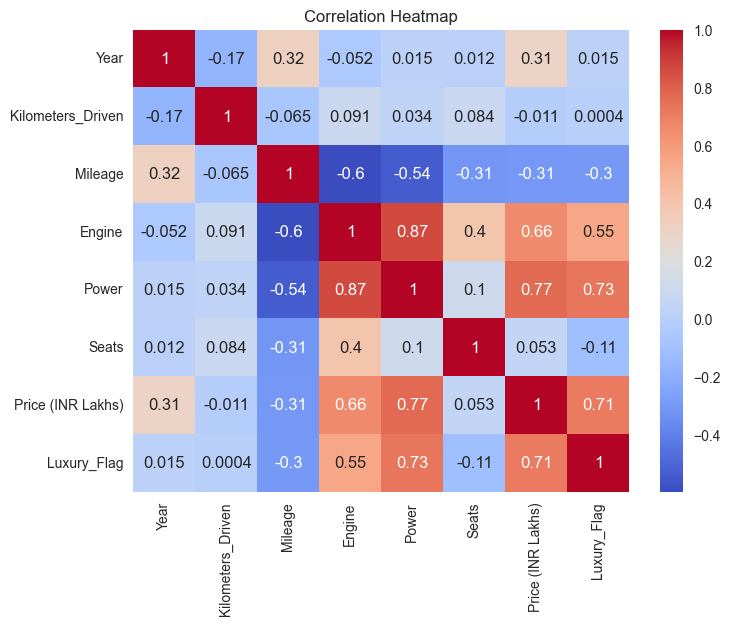

In [30]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- **Year**: Newer cars (higher Year) are moderately correlated with higher prices (0.31) and better mileage (0.32). This suggests that newer vehicles are more expensive and fuel-efficient aligning with expectations.

- **Kilometers_Driven**: Older vehicles (lower Year) tend to have higher mileage (-0.17), but this metric has negligible correlation with price (-0.011). This suggests that age is a more significant factor in pricing than mileage.
- **Mileage**: Higher mileage (better fuel efficiency) is strongly negatively correlated with engine size (-0.6) and power (-0.54), and moderately inversely linked to price (-0.31). This suggests that smaller engines and less powerful vehicles are more fuel-efficient which is expected.
- **Engine**: Engine size is strongly correlated with power (0.87) and luxury status (0.55), and moderately linked to higher prices (0.66). This makes sense as larger engines are typically more powerful and expensive which can be seen more often in luxury vehicles.
- **Power**: Power output is strongly correlated with luxury status (0.73) and price (0.77), and moderately linked to engine size (0.87). This suggests that luxury vehicles tend to have more powerful engines and are more expensive as mentioned earlier.
- **Seats**: Seat count has weak correlations with most variables, but shows a slight positive link to engine size (0.39). This could be due to larger vehicles like SUVs or vans having more seats and larger engines to accommodate the extra weight.
- **Price (INR Lakhs)**: Price is strongly influenced by luxury status (0.71), power (0.77), and engine size (0.66), with a moderate positive correlation to year (0.31).
- **Luxury_Flag**: Luxury vehicles are strongly correlated with higher power (0.73) and price (0.71), and moderately linked to larger engines (0.55). Larger engines and more powerful vehicles are typically more expensive and luxurious, for example, sports cars or luxury sedans.

<Figure size 800x400 with 0 Axes>

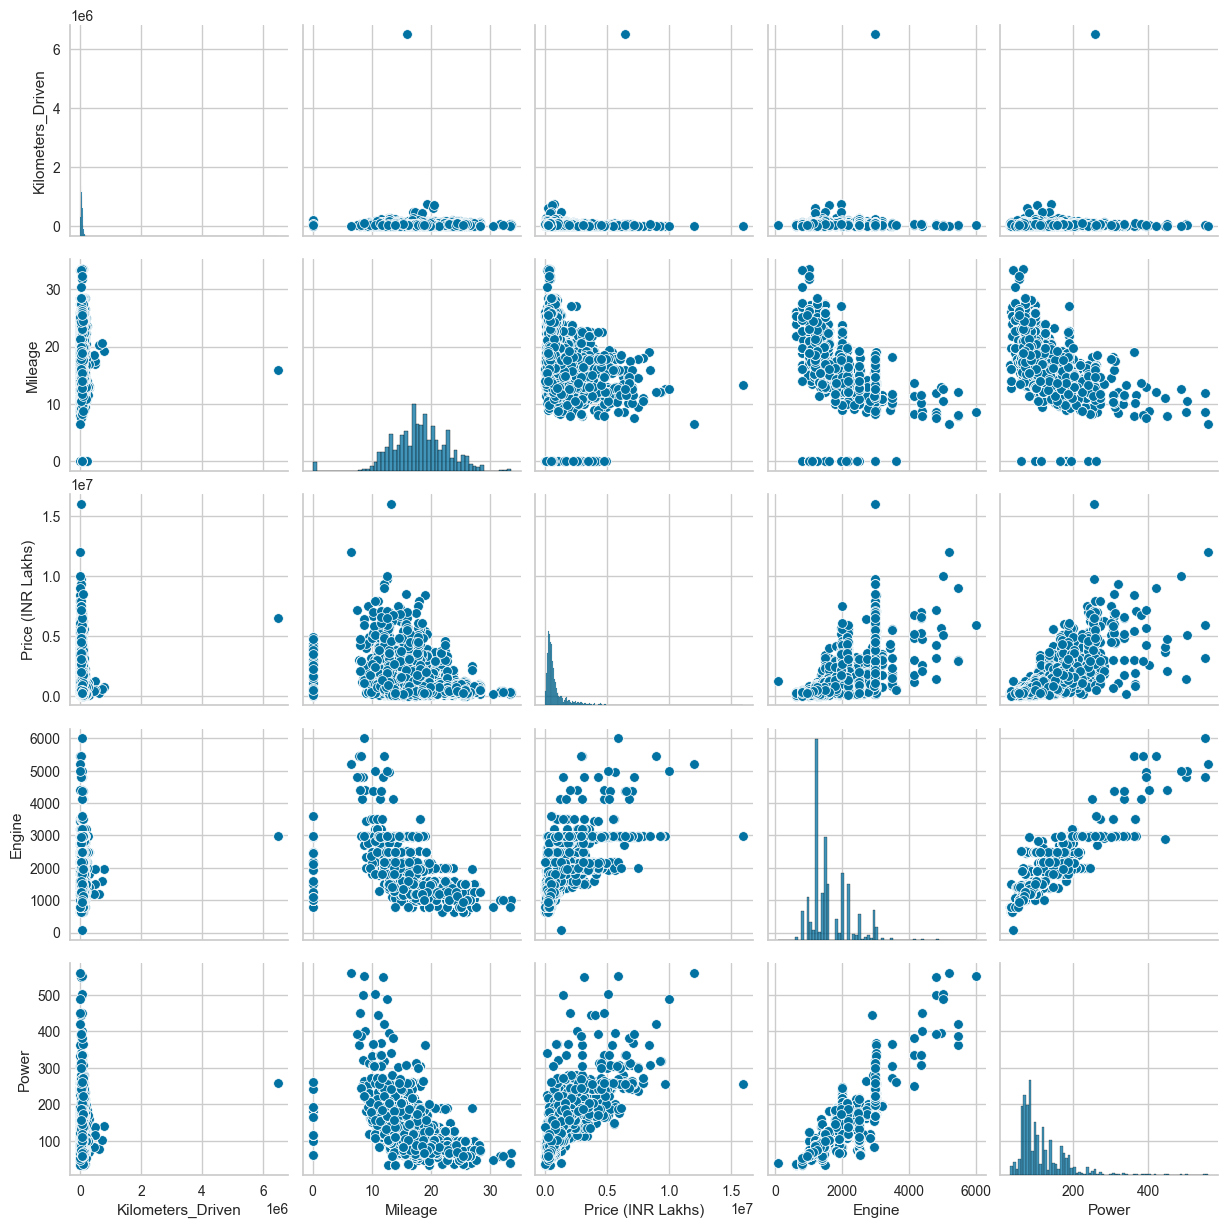

In [31]:
# Pair Plot
plt.figure(figsize=(8, 4))
sns.pairplot(data[['Kilometers_Driven', 'Mileage', 'Price (INR Lakhs)', 'Engine', 'Power']])
plt.show()


**1. Kilometers_Driven**  
- **Distribution**: Distribution is highly right-skewed, with most vehicles under 100,000 km and outliers up to 6,000,000 km.  
- **Relationships**:  
  - Weak negative correlation with **Price** (higher kilometers may slightly reduce price, but noise dominates).  
  - No clear relationship with **Mileage**, **Engine**, or **Power**.  

**2. Mileage**  
- **Distribution**: Clustered between 10–25 kmpl, with a few outliers spotted. 
- **Relationships**:  
  - Weak positive correlation with **Price** (better mileage may increase price slightly).
  - Strong negative correlation with **Engine** (larger engines typically have lower mileage).  
  - Moderate negative correlation with **Power** (higher power often reduces fuel efficiency). 

**3. Price (INR Lakhs)**  
- **Distribution**: Strongly right-skewed, with most cars priced below ₹1,000,000 (outliers up to ₹16,000,000).  
- **Relationships**:  
  - Strong positive correlation with **Engine** (larger engines correlate with higher prices).  
  - Strong positive correlation with **Power** (more powerful cars are pricier).  
  - Weak negative correlation with **Kilometers_Driven** (mileage has minimal impact on price).  

**4. Engine**  
- **Distribution**: Peaks at 1,000–2,000 cc, with a long tail for larger engines.  
- **Relationships**:  
  - Strong positive correlation with **Power** (larger engines deliver more power).  
  - Strong negative correlation with **Mileage** (larger engines reduce fuel efficiency).  
  - Moderate positive correlation with **Price** (larger engines increase cost).  

**5. Power**  
- **Distribution**: Clustered between 50–200 HP, with outliers up to 580 HP.  
- **Relationships**:  
  - Strong positive correlation with **Engine** (engine size drives power output).  
  - Strong positive correlation with **Price** (higher power increases cost).  
  - Moderate negative correlation with **Mileage** (powerful cars often have lower fuel efficiency).

Overall, the skewed distributions may be fixed by removing outliers or transforming the data, and the relationships between variables suggest multicollinearity which may require regularization or feature engineering to address.

In [32]:
# save data to processed
data.to_excel('../data/processed/02_Used_Car_Prices.xlsx', index=False)

### **3. PyCaret Setup**

In [21]:
exp_reg = setup(
    data=data,
    target='Price (INR Lakhs)',
    categorical_features=['Location', 'Fuel_Type', 'Transmission', 'Brand', 'Luxury_Flag'],
    ordinal_features={'Owner_Type': ['First', 'Second', 'Third', 'Fourth & Above']},
    numeric_features=['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats'],
    bin_numeric_features=['Kilometers_Driven'],
    ignore_features=['Brand_Model'],
    imputation_type='iterative',
    iterative_imputation_iters=10,
    numeric_iterative_imputer='et',
    categorical_iterative_imputer='et',
    rare_to_value=0.1,
    normalize=True,
    remove_multicollinearity=True,
    remove_outliers=True,
    train_size=0.8,
    session_id=123,
    log_experiment=True,
    experiment_name='used_car_prices'
)

,Description,Value
0,Session id,123
1,Target,Price (INR Lakhs)
2,Target type,Regression
3,Original data shape,"(6019, 14)"
4,Transformed data shape,"(5779, 23)"
5,Transformed train set shape,"(4575, 23)"
6,Transformed test set shape,"(1204, 23)"
7,Ignore features,1
8,Ordinal features,1
9,Numeric features,6


2025/02/26 13:59:18 INFO mlflow.tracking.fluent: Experiment with name 'used_car_prices' does not exist. Creating a new experiment.


Here we define the setup for PyCaret where we set `Price (INR Lakhs)` as the target variable.

The setup is configured to:
- Use 80% of the data for training and 20% for testing.
- A random seed for reproducibility which is set to 123.
- We will normalize the data using Z-score normalization.
- Set the appropriate categorical, ordinal, and numerical features.
- Imputation using iterative imputer with extra trees as the estimator set to 10 iterations.
- Multicollinearity check is enabled to identify and remove highly correlated features from the dataset.
- Remove outliers with threshold set to 0.05 which removes 5% of the data from the tails of the distribution.
- Use rare_to_value to combining the rare levels in the feature(or features) having high cardinality.
- Ignore the Model_Name column as it contains too many unique values.
- Experiment is logged to MLFlow for tracking and reproducibility.

### **4. Model Building**                                                                                       

In [22]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,137130.9988,100291866709.9361,305801.4657,0.9187,0.2256,0.1677,1.3480
xgboost,Extreme Gradient Boosting,144684.5516,123778306457.6000,344443.1047,0.8979,0.2259,0.1661,0.6430
et,Extra Trees Regressor,155795.2120,125220404617.2230,344882.2935,0.8973,0.2347,0.1826,0.9020
lightgbm,Light Gradient Boosting Machine,151471.1129,129646033127.9048,352667.0881,0.8921,0.2428,0.1841,0.6920
rf,Random Forest Regressor,153284.2970,133532384886.7771,357187.2168,0.8895,0.2344,0.1802,0.8820
gbr,Gradient Boosting Regressor,172470.2448,141856941711.5015,369109.3619,0.8806,0.2797,0.2209,0.6630
dt,Decision Tree Regressor,192318.7632,209502523114.4208,447274.4186,0.8281,0.2955,0.2208,0.5800
knn,K Neighbors Regressor,229961.2234,219408361062.4000,462300.9812,0.8162,0.3297,0.2778,0.5820
lasso,Lasso Regression,305133.6601,283227381615.3545,528807.3147,0.7576,0.6631,0.5916,0.6500
br,Bayesian Ridge,304809.0182,283277603808.3508,528819.5194,0.7576,0.6686,0.5899,0.5840


By using compare_models function, we can identify the best performing model based on the metric we choose. We will use the default metric which is R2 score to identify the best model.

After running it we can observe that CatBoost Regressor is the top-performing model across most metrics:
- Lowest MAE (137,131), RMSE (305,801), and RMSLE (0.2256) values.
- Highest R² (0.9187), indicating strong explanatory power of the model.
- Slightly higher MAPE (0.1677) compared to XGBoost but negligible in practical terms.
- TT (Time Taken) is 1.6380 seconds, not as fast as xgboost but still reasonable.


### **5. Model Tuning**

Here we will use the tune_model function to tune the CatBoost Regressor model. Additionally, we will use optuna as the search libary with custom hyperparameters.

These are the hyperparameters that we will tune:
- **learning_rate**: Determines the contribution of each tree to the final prediction. Lower values can improve generalization but require more iterations.
- **depth**: Depth of the tree, higher depth will allow the model to capture more information but can also lead to overfitting.
- **colsample_bylevel**: Subsample ratio of columns for each level, lower values can reduce overfitting.
- **min_data_in_leaf**: Minimal number of data in one leaf. Acts as a smoothing parameter for leaf predictions.

Why These Parameters?
- **Bias-Variance Tradeoff:** `depth`, `subsample`, and `min_data_in_leaf` control model complexity.
- **Learning Dynamics:** `iterations` balance speed and convergence.
- **Regularization:** `colsample_bylevel` and subsample add stochasticity to prevent overfitting.

In [23]:
# tune the best model
custom_grid = {
    # "iterations": DiscreteUniformDistribution(100, 1000, 100),
    "learning_rate": UniformDistribution(1e-3, 0.1, log=True), 
    "depth": IntUniformDistribution(4, 10),
    "subsample": UniformDistribution(0.05, 1.0), 
    "colsample_bylevel": UniformDistribution(0.05, 1.0), 
    "min_data_in_leaf": IntUniformDistribution(1, 120)
}

tuned_model = tune_model(best_model, search_library='optuna', custom_grid=custom_grid, n_iter=30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,125577.6428,54425286785.5601,233292.2776,0.9511,0.2264,0.1686
1,142098.8561,74089083641.0401,272193.0999,0.9326,0.2456,0.1764
2,149337.8337,97817176620.7336,312757.3766,0.9346,0.2173,0.1506
3,136872.1199,60145619298.1288,245246.0383,0.9462,0.2400,0.1707
4,120657.7014,79915667602.4563,282693.5931,0.9218,0.2293,0.1685
5,122367.4060,43615599509.0663,208843.4809,0.9482,0.2301,0.1778
6,160923.5489,115894756747.1749,340433.1898,0.9124,0.2233,0.1731
7,180815.9928,239584736161.0962,489473.9382,0.8589,0.2366,0.1743
8,134057.6484,66502751049.6751,257881.2732,0.9157,0.2419,0.1895


After tuning, the model was evaluated using 10-fold cross-validation.

We can observe that the tuned model improves RMSE and R2 but slightly sacrifices MAE and MAPE. This suggests the tuning process prioritized reducing large errors (beneficial for RMSE) at the cost of small-to-moderate errors (critical for MAE/MAPE).

In [24]:
# finalize the model
final_model = finalize_model(tuned_model)

### **6. Model Evaluation**

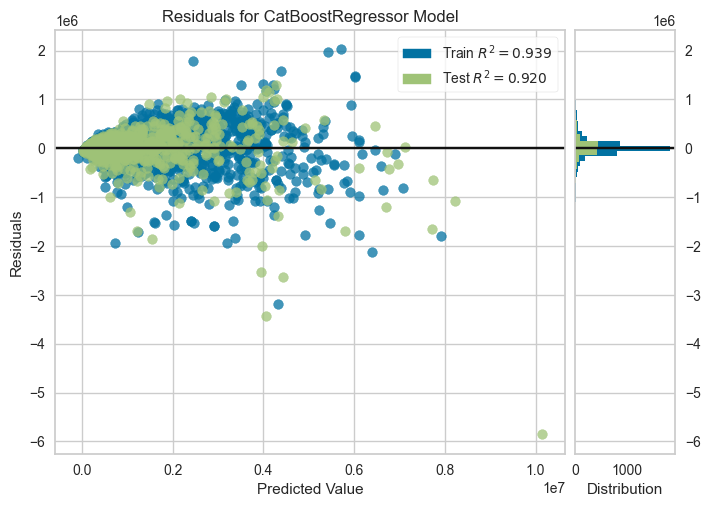

In [25]:
# plot residuals
plot_model(final_model, plot='residuals')

Residuals are centered around zero with no clear patterns, indicating the model captures linear relationships well. But the Training R2 of 0.939 vs Testing R2 of 0.920 can indicate slight overfitting (1.9% drop), but the model generalizes reasonably.

There are also some instances where a few large residuals (+- 2M INR) suggest the model struggles with extreme values like very cheap or expensive cars.

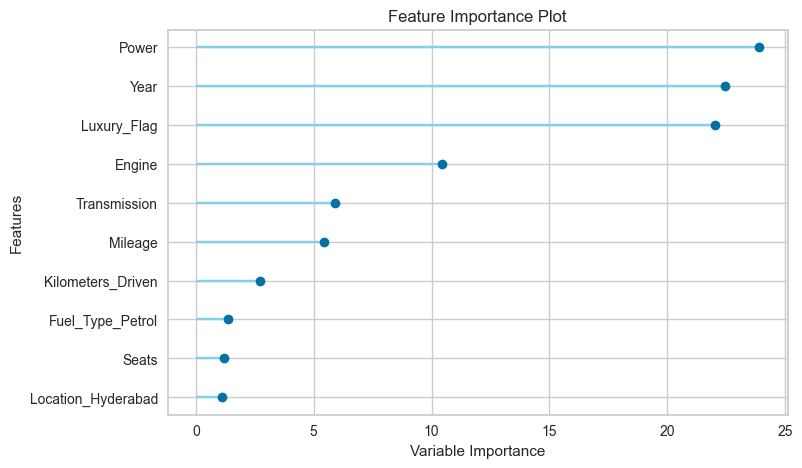

In [26]:
# plot feature importance
plot_model(final_model, plot='feature')

Top Drivers:
- Power and Year are the strongest predictors, this findings aligns with EDA and domain knowledge (powerful/newer cars are pricier).
- Luxury_Flag and Engine also heavily influence price, reflecting performance and luxury premiums. Indicating that luxury vehicles have more influence on price than non-luxury vehicles.
- Transmission and Mileagehave moderate impact, while Kilometers_Driven and Fuel_Type_Petrol are less critical.

Low Impact:
- Seats and Location_Hyderabad suggest these features add minimal predictive value.

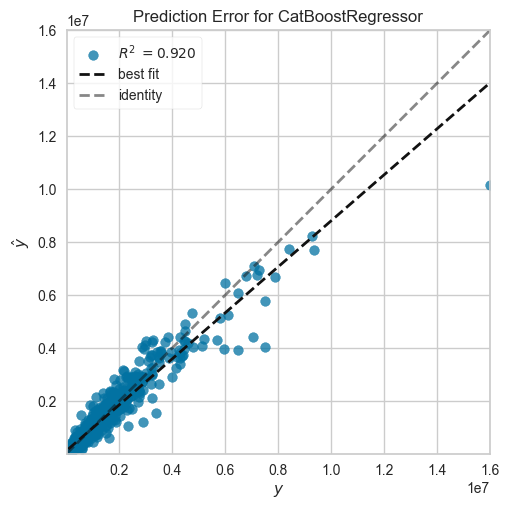

In [27]:
# plot prediction error
plot_model(final_model, plot='error')

We can see a strong correlation between predictions and actual values, while the model underestimates prices for cars >10M, likely due to limited data or feature gaps for luxury vehicle.

In [46]:
# evaluate the model
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### **7. Register to Mlflow**

In [ ]:
# save the model
save_model(final_model, '../models/final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('iterative_imputer',
                  TransformerWrapper(transformer=IterativeImputer(cat_estimator=ExtraTreesClassifier(n_jobs=-1,
                                                                                                     random_state=123),
                                                                  cat_estimator_prepare_for_categoricals_type='ordinal',
                                                                  categorical_indices=[0,
                                                                                       3,
                                                                                       4,
                                                                                       10,
                                                                                       11],
                                                                  num_estimator=ExtraTreesRegressor(n_jobs=-1,
    

In [38]:
# register the model to MLflow
mlflow.catboost.log_model(
    cb_model=final_model,
    artifact_path='used_car_prices_model'
)

2025/02/26 14:20:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Damian\AppData\Local\Temp\tmpfcgrnxda\model, flavor: catboost). Fall back to return ['catboost==1.2.7']. Set logging level to DEBUG to see the full traceback. 


In [40]:
# log metrics
metrics = pull()
mlflow.log_metrics({
    'MAE': metrics['MAE'],
    'MSE': metrics['MSE'],
    'RMSE': metrics['RMSE'],
    'R2': metrics['R2'],
    'MAPE': metrics['MAPE']
})

### **8. Load Model and Predict**

In [ ]:
# load the model
loaded_model = load_model('../models/final_model')

Transformation Pipeline and Model Successfully Loaded


In [49]:
unseen_data = data.sample(3)

In [50]:
# predict on unseen data
predictions = predict_model(loaded_model, data=unseen_data)
predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,46456.7400,2472308567.1823,49722.3146,0.9863,0.0850,0.0727


,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Luxury_Flag,Price (INR Lakhs),prediction_label
5621,Toyota Fortuner 4x2 4 Speed AT,Pune,2012,125000,Diesel,Automatic,First,11.50,2982.00,169.00,7.00,Toyota,0,1350000.00,1285262.71
6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.00,74.00,5.00,Maruti,0,475000.00,497467.70
3498,Maruti Swift VDI,Jaipur,2012,80000,Diesel,Manual,First,22.90,1248.00,74.00,5.00,Maruti,0,425000.00,372834.76


### **9. Conclusion**
Overall, the CatBoost Regressor model is a strong performer for predicting used car prices, with a R2 of 0.920 and RMSE of 2,97,000 INR. The model is well-suited for explaining the price variance in the dataset, with key drivers being power, year, luxury status, and engine size. We can use this model to predict car prices with reasonable accuracy, but further improvements can be made by collecting more data on luxury vehicles and expanding the feature set to include more detailed information on car specifications.